# Analysis of Duchess' Eating Habits
William Reames

## Imports

In [1]:
import pandas as pd
import numpy as np

# Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Test/Train Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

import plotly.express as px
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

from sklearn.tree import plot_tree

## Variables Used in During Data Analysis

In [2]:
minimum_satisfactory_immediate_eaten = 0.40
minimum_satisfactory_total_eaten = 0.80
num_previous_meals_to_check = 6  # This is used when checking how many times Duchess was given the same meal
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Importing the Dataset

In [3]:
df = pd.read_csv('../data/duchess-eating-habits.csv')

In [4]:
df.head()

,Date,Meal,Brand,Flavor,Type,Initial Temperature,Microwaved,Added Water,Immediate % Eaten,Total % Eaten,Notes
0,10/25/2023,Lunch,Friskies,Salmon & Gravy,Chunky extra gravy,Cold,False,False,5%,10%,NaN
1,10/25/2023,Dinner,Friskies,Turkey & Cheese,Shreds,Room,False,False,60%,100%,NaN
2,10/26/2023,Lunch,Friskies,Turkey & Cheese,Shreds,Cold,False,False,25%,80%,NaN
3,10/26/2023,Dinner,Friskies,Whitefish & Sardines,Shreds,Room,False,False,30%,95%,NaN
4,10/27/2023,Lunch,Friskies,Whitefish & Sardines,Shreds,Cold,False,False,15%,60%,NaN


## Cleaning the Data

### Dropping unecessary data

In [5]:
df = df[~df['Meal'].isnull()]

In [6]:
df = df.drop('Notes', axis=1)

In [7]:
df = df.drop('Date', axis=1)

In [8]:
df.head()

,Meal,Brand,Flavor,Type,Initial Temperature,Microwaved,Added Water,Immediate % Eaten,Total % Eaten
0,Lunch,Friskies,Salmon & Gravy,Chunky extra gravy,Cold,False,False,5%,10%
1,Dinner,Friskies,Turkey & Cheese,Shreds,Room,False,False,60%,100%
2,Lunch,Friskies,Turkey & Cheese,Shreds,Cold,False,False,25%,80%
3,Dinner,Friskies,Whitefish & Sardines,Shreds,Room,False,False,30%,95%
4,Lunch,Friskies,Whitefish & Sardines,Shreds,Cold,False,False,15%,60%


In [9]:
df.index.size

53

### Converting % eaten data to integer values

Converting values

In [10]:
df['immediate_eaten'] = pd.to_numeric(df['Immediate % Eaten'].str.replace('%', '')) / 100
df = df.drop('Immediate % Eaten', axis=1)

In [11]:
df['total_eaten'] = pd.to_numeric(df['Total % Eaten'].str.replace('%', '')) / 100
df = df.drop('Total % Eaten', axis=1)

In [12]:
df.head()

,Meal,Brand,Flavor,Type,Initial Temperature,Microwaved,Added Water,immediate_eaten,total_eaten
0,Lunch,Friskies,Salmon & Gravy,Chunky extra gravy,Cold,False,False,0.05,0.10
1,Dinner,Friskies,Turkey & Cheese,Shreds,Room,False,False,0.60,1.00
2,Lunch,Friskies,Turkey & Cheese,Shreds,Cold,False,False,0.25,0.80
3,Dinner,Friskies,Whitefish & Sardines,Shreds,Room,False,False,0.30,0.95
4,Lunch,Friskies,Whitefish & Sardines,Shreds,Cold,False,False,0.15,0.60


Updating NaN values to average values

In [13]:
average_immediate_eaten = round(df['immediate_eaten'].mean(), 2)
average_total_eaten = round(df['total_eaten'].mean(), 2)
df['immediate_eaten'] = df['immediate_eaten'].fillna(average_immediate_eaten)
df['total_eaten'] = df['total_eaten'].fillna(average_total_eaten)

print(f'Average immediate amount eaten: {average_immediate_eaten}')
print(f'Average total amount eaten:     {average_total_eaten}')

Average immediate amount eaten: 0.31
Average total amount eaten:     0.72


### Determining food satisfaction levels

In [14]:
df['satisfactory_immediate_eaten'] = df['immediate_eaten'] >= minimum_satisfactory_immediate_eaten
df['satisfactory_total_eaten'] = df['total_eaten'] >= minimum_satisfactory_total_eaten

In [15]:
df.head()

,Meal,Brand,Flavor,Type,Initial Temperature,Microwaved,Added Water,immediate_eaten,total_eaten,satisfactory_immediate_eaten,satisfactory_total_eaten
0,Lunch,Friskies,Salmon & Gravy,Chunky extra gravy,Cold,False,False,0.05,0.10,False,False
1,Dinner,Friskies,Turkey & Cheese,Shreds,Room,False,False,0.60,1.00,True,True
2,Lunch,Friskies,Turkey & Cheese,Shreds,Cold,False,False,0.25,0.80,False,True
3,Dinner,Friskies,Whitefish & Sardines,Shreds,Room,False,False,0.30,0.95,False,True
4,Lunch,Friskies,Whitefish & Sardines,Shreds,Cold,False,False,0.15,0.60,False,False


### Adding relevant data to each row based on previous rows

Adding a column for the previous meal's total_eaten value

In [16]:
for i in range(df.index.size):
    if i > 0 and df.loc[i - 1, 'total_eaten']:
        df.loc[i, 'previous_total_eaten'] = df.loc[i - 1, 'total_eaten']
    else:
        df.loc[i, 'previous_total_eaten'] = average_total_eaten

In [17]:
df.head()

,Meal,Brand,Flavor,Type,Initial Temperature,Microwaved,Added Water,immediate_eaten,total_eaten,satisfactory_immediate_eaten,satisfactory_total_eaten,previous_total_eaten
0,Lunch,Friskies,Salmon & Gravy,Chunky extra gravy,Cold,False,False,0.05,0.10,False,False,0.72
1,Dinner,Friskies,Turkey & Cheese,Shreds,Room,False,False,0.60,1.00,True,True,0.10
2,Lunch,Friskies,Turkey & Cheese,Shreds,Cold,False,False,0.25,0.80,False,True,1.00
3,Dinner,Friskies,Whitefish & Sardines,Shreds,Room,False,False,0.30,0.95,False,True,0.80
4,Lunch,Friskies,Whitefish & Sardines,Shreds,Cold,False,False,0.15,0.60,False,False,0.95


Adding a column for the number of times that flavor was served during the previous 6 meals

In [18]:
for i in range(df.index.size):
    if i == 0:
        df.loc[i, 'num_same_previous_meals'] = 0
        continue
    min_index = i - num_previous_meals_to_check if i > num_previous_meals_to_check else 0
    max_index = i - 1 if i > 1 else 0
    meal_count = list(df.loc[min_index:max_index, 'Flavor']).count(df.loc[i, 'Flavor'])
    df.loc[i, 'num_same_previous_meals'] = meal_count

In [19]:
df.head()

,Meal,Brand,Flavor,Type,Initial Temperature,Microwaved,Added Water,immediate_eaten,total_eaten,satisfactory_immediate_eaten,satisfactory_total_eaten,previous_total_eaten,num_same_previous_meals
0,Lunch,Friskies,Salmon & Gravy,Chunky extra gravy,Cold,False,False,0.05,0.10,False,False,0.72,0.0
1,Dinner,Friskies,Turkey & Cheese,Shreds,Room,False,False,0.60,1.00,True,True,0.10,0.0
2,Lunch,Friskies,Turkey & Cheese,Shreds,Cold,False,False,0.25,0.80,False,True,1.00,1.0
3,Dinner,Friskies,Whitefish & Sardines,Shreds,Room,False,False,0.30,0.95,False,True,0.80,0.0
4,Lunch,Friskies,Whitefish & Sardines,Shreds,Cold,False,False,0.15,0.60,False,False,0.95,1.0


### Creating binary encodings

Lunch vs Dinner

In [20]:
df['lunch'] = pd.get_dummies(df['Meal'])['Lunch']
df = df.drop('Meal', axis=1)

Room vs Cold initial temperature

In [21]:
df['initially_cold'] = pd.get_dummies(df['Initial Temperature'])['Cold']
df = df.drop('Initial Temperature', axis=1)

In [22]:
df.head()

,Brand,Flavor,Type,Microwaved,Added Water,immediate_eaten,total_eaten,satisfactory_immediate_eaten,satisfactory_total_eaten,previous_total_eaten,num_same_previous_meals,lunch,initially_cold
0,Friskies,Salmon & Gravy,Chunky extra gravy,False,False,0.05,0.10,False,False,0.72,0.0,1,1
1,Friskies,Turkey & Cheese,Shreds,False,False,0.60,1.00,True,True,0.10,0.0,0,0
2,Friskies,Turkey & Cheese,Shreds,False,False,0.25,0.80,False,True,1.00,1.0,1,1
3,Friskies,Whitefish & Sardines,Shreds,False,False,0.30,0.95,False,True,0.80,0.0,0,0
4,Friskies,Whitefish & Sardines,Shreds,False,False,0.15,0.60,False,False,0.95,1.0,1,1


### Creating one-hot encodings

Flavors

In [23]:
df['Flavor'] = df['Flavor'].str.lower()
df['Flavor'] = df['Flavor'].str.replace('ocean whitefish', 'whitefish')
df['Flavor'] = df['Flavor'].str.replace('grain free salmon', 'salmon')

In [24]:
df[['flavor_1', 'flavor_2']] = df['Flavor'].str.split(' & ', expand=True)
df = df.drop('Flavor', axis=1)

In [25]:
df = pd.concat([df, pd.get_dummies(df['flavor_1'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['flavor_2'])], axis=1)
df = df.drop('flavor_1', axis=1)
df = df.drop('flavor_2', axis=1)

Brand

In [26]:
df = pd.concat([df, pd.get_dummies(df['Brand'].str.lower())], axis=1)
df = df.drop('Brand', axis=1)

Food type

In [27]:
df = pd.concat([df, pd.get_dummies(df['Type'].str.lower())], axis=1)
df = df.drop('Type', axis=1)

In [28]:
df.head()

,Microwaved,Added Water,immediate_eaten,total_eaten,satisfactory_immediate_eaten,satisfactory_total_eaten,previous_total_eaten,num_same_previous_meals,lunch,initially_cold,chicken,country style,mariner's catch,mixed grill,salmon,turkey,whitefish,cheese,giblets,gravy,sardines,tuna,blue wilderness,friskies,open nature,chunky extra gravy,meaty bits,pate,prime filets,shreds
0,False,False,0.05,0.10,False,False,0.72,0.0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
1,False,False,0.60,1.00,True,True,0.10,0.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,False,False,0.25,0.80,False,True,1.00,1.0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,False,False,0.30,0.95,False,True,0.80,0.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
4,False,False,0.15,0.60,False,False,0.95,1.0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1


### Setting X and Y

In [29]:
X = df.drop(['immediate_eaten', 'total_eaten', 'satisfactory_immediate_eaten', 'satisfactory_total_eaten'], axis=1)
Y_immediate = df['satisfactory_immediate_eaten']
Y_total = df['satisfactory_total_eaten']

In [30]:
X.head()

,Microwaved,Added Water,previous_total_eaten,num_same_previous_meals,lunch,initially_cold,chicken,country style,mariner's catch,mixed grill,salmon,turkey,whitefish,cheese,giblets,gravy,sardines,tuna,blue wilderness,friskies,open nature,chunky extra gravy,meaty bits,pate,prime filets,shreds
0,False,False,0.72,0.0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
1,False,False,0.10,0.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,False,False,1.00,1.0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,False,False,0.80,0.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
4,False,False,0.95,1.0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1


In [31]:
Y_immediate.value_counts()

False    36
True     17
Name: satisfactory_immediate_eaten, dtype: int64

In [32]:
Y_total.value_counts()

False    27
True     26
Name: satisfactory_total_eaten, dtype: int64

In [33]:
x_immediate_train, x_immediate_test, y_immediate_train, y_immediate_test = train_test_split(X, Y_immediate)
x_total_train, x_total_test, y_total_train, y_total_test = train_test_split(X, Y_total)

## Visualizing the Data

In [69]:
df.columns

Index(['Microwaved', 'Added Water', 'immediate_eaten', 'total_eaten',
       'satisfactory_immediate_eaten', 'satisfactory_total_eaten',
       'previous_total_eaten', 'num_same_previous_meals', 'lunch',
       'initially_cold', 'chicken', 'country style', 'mariner's catch',
       'mixed grill', 'salmon', 'turkey', 'whitefish', 'cheese', 'giblets',
       'gravy', 'sardines', 'tuna', 'blue wilderness', 'friskies',
       'open nature', 'chunky extra gravy', 'meaty bits', 'pate',
       'prime filets', 'shreds'],
      dtype='object')

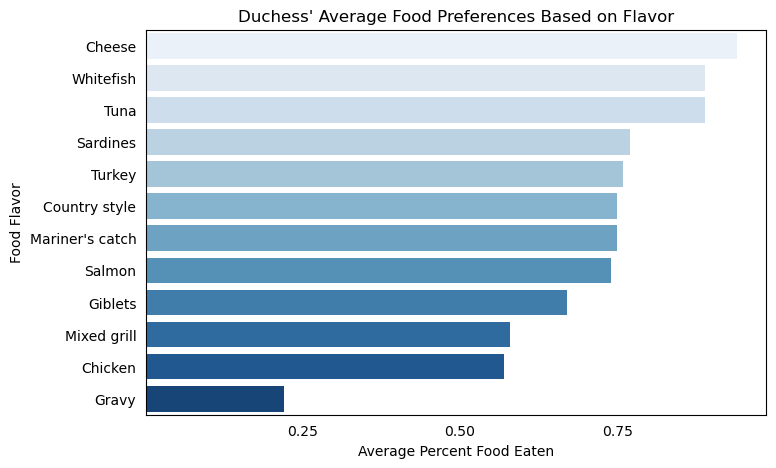

In [157]:
# Plotting the average percent eaten for each food flavor

features_to_not_use = ['Microwaved', 'Added Water', 'immediate_eaten', 'total_eaten',
       'satisfactory_immediate_eaten', 'satisfactory_total_eaten',
       'previous_total_eaten', 'num_same_previous_meals', 'lunch',
       'initially_cold', 'blue wilderness', 'friskies',
       'open nature', 'chunky extra gravy', 'meaty bits', 'pate',
       'prime filets', 'shreds']

averages = dict()

for feature in df.columns:
    if feature in features_to_not_use:
        continue
    averages[feature.capitalize()] = [round(df[df[feature] == 1]['total_eaten'].mean(), 2)]


averages_df = pd.DataFrame.from_dict(averages)
averages_df = averages_df.sort_values(0, axis=1, ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(averages_df, orient="h", palette="Blues")

ax.set_xlabel('Average Percent Food Eaten')
ax.set_ylabel('Food Flavor')
ax.set_title("Duchess' Average Food Preferences Based on Flavor")

ax.set_xticks([0.25, 0.5, 0.75])
plt.tick_params(left=False, bottom=False)
plt.savefig('../images/average-based-on-flavor')
_;

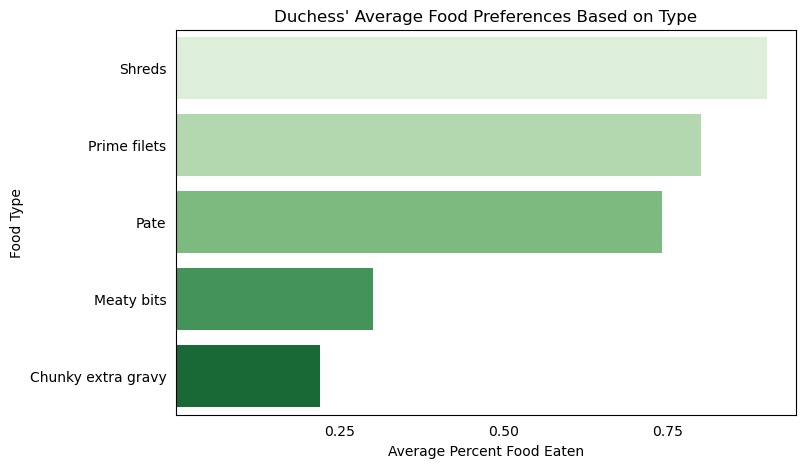

In [158]:
# Plotting the average percent eaten for each food type

features_to_not_use = ['Microwaved', 'Added Water', 'immediate_eaten', 'total_eaten',
       'satisfactory_immediate_eaten', 'satisfactory_total_eaten',
       'previous_total_eaten', 'num_same_previous_meals', 'lunch',
       'initially_cold', 'blue wilderness', 'friskies',
       'open nature', 'chicken', 'country style', 'mariner\'s catch',
       'mixed grill', 'salmon', 'turkey', 'whitefish', 'cheese', 'giblets',
       'gravy', 'sardines', 'tuna']

averages = dict()

for feature in df.columns:
    if feature in features_to_not_use:
        continue
    averages[feature.capitalize()] = [round(df[df[feature] == 1]['total_eaten'].mean(), 2)]


averages_df = pd.DataFrame.from_dict(averages)
averages_df = averages_df.sort_values(0, axis=1, ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(averages_df, orient="h", palette="Greens")

ax.set_xlabel('Average Percent Food Eaten')
ax.set_ylabel('Food Type')
ax.set_title("Duchess' Average Food Preferences Based on Type")

ax.set_xticks([0.25, 0.5, 0.75])
plt.tick_params(left=False, bottom=False)
plt.savefig('../images/average-based-on-type')
_;

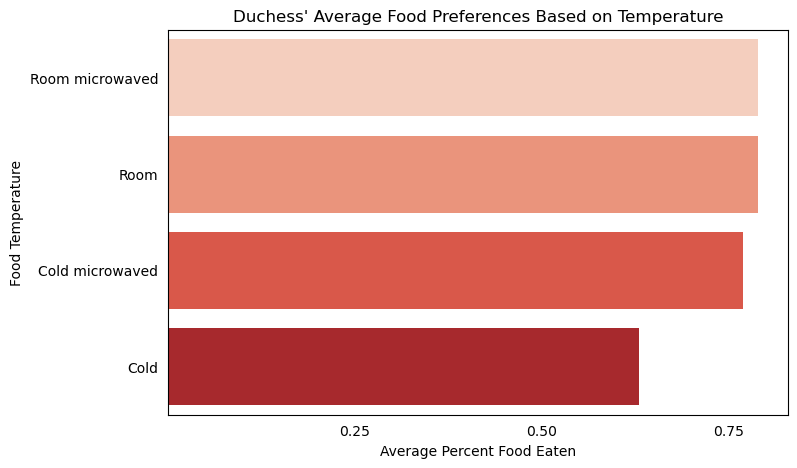

In [159]:
# Plotting the average percent eaten for each food temperature

averages = dict()

cold_classifier = df['initially_cold'] == 1 & ~df['Microwaved']
cold_warmed_classifier = df['initially_cold'] == 1 & df['Microwaved']
room_classifier = df['initially_cold'] == 0 & ~df['Microwaved']
room_warmed_classifier = df['initially_cold'] == 0 & df['Microwaved']

averages['Room microwaved'] = [round(df[room_warmed_classifier]['total_eaten'].mean(), 2)]
averages['Room'] = [round(df[room_classifier]['total_eaten'].mean(), 2)]
averages['Cold microwaved'] = [round(df[cold_warmed_classifier]['total_eaten'].mean(), 2)]
averages['Cold'] = [round(df[cold_classifier]['total_eaten'].mean(), 2)]



averages_df = pd.DataFrame.from_dict(averages)
# averages_df = averages_df.sort_values(0, axis=1, ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(averages_df, orient="h", palette="Reds")

ax.set_xlabel('Average Percent Food Eaten')
ax.set_ylabel('Food Temperature')
ax.set_title("Duchess' Average Food Preferences Based on Temperature")

ax.set_xticks([0.25, 0.5, 0.75])
plt.tick_params(left=False, bottom=False)
plt.savefig('../images/average-based-on-temperature')

_;

### TSNE

In [36]:
tsne_x = TSNE().fit_transform(X)

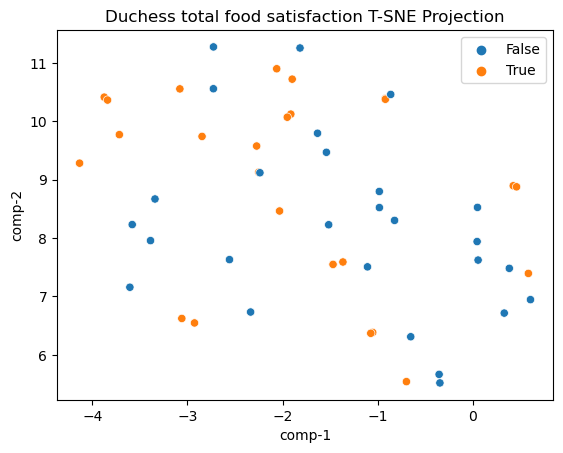

In [38]:
tsne_df = pd.DataFrame()
tsne_df["y"] = Y_total
tsne_df["comp-1"] = tsne_x[:,0]
tsne_df["comp-2"] = tsne_x[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=tsne_df.y.tolist(),
                data=tsne_df).set(title="Duchess total food satisfaction T-SNE Projection") 

plt.show()

## Analyzing the Data

### Useful Functions

In [39]:
def plot_confusion_matrix(y, y_hat, title=None):
    confusion_matrix = metrics.confusion_matrix(y, y_hat)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix, 
        display_labels = [False, True],
    )
    cm_display.plot()
    plt.title(title)

In [40]:
def print_metrics(y, y_hat):
    accuracy = metrics.accuracy_score(y, y_hat)
    precision = metrics.precision_score(y, y_hat, zero_division=0)
    recall = metrics.recall_score(y, y_hat, zero_division=0)
    f1 = metrics.f1_score(y, y_hat, zero_division=0)
    print(
        f"""
        accuracy:  {accuracy:0.6f}
        precision: {precision:0.6f}
        recall:    {recall:0.6f}
        f1:        {f1:0.6f}
        """
    )

In [41]:
def perform_grid_search(classifier, x_train, y_train, x_test, y_test, param_grid, cv=5, title=None):
    classifier_grid_search = GridSearchCV(classifier, param_grid, cv=cv)
    classifier_grid_search.fit(x_train, y_train)
    print(f'Best parameters: {classifier_grid_search.best_params_}')
    print(f'Best score: {classifier_grid_search.best_score_:0.6f}')
    
    predictions = classifier_grid_search.predict(x_test)
    plot_confusion_matrix(y_test, predictions, title)
    print_metrics(y_test, predictions)
    
    return classifier_grid_search

### Majority Class Baseline

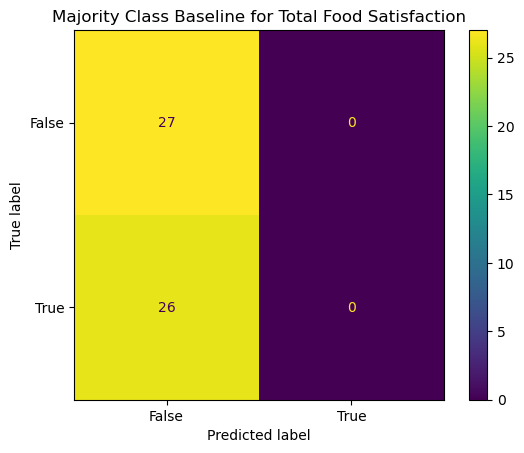


        accuracy:  0.509434
        precision: 0.000000
        recall:    0.000000
        f1:        0.000000
        


In [43]:
num_true = Y_total.value_counts()[1]
num_false = Y_total.value_counts()[0]

if num_true >= num_false:
    y_hat = np.ones(len(Y_total))
else:
    y_hat = np.zeros(len(Y_total))

plot_confusion_matrix(Y_total, y_hat, title='Majority Class Baseline for Total Food Satisfaction')
plt.show()

print_metrics(Y_total, y_hat)

### Decision Tree

Best parameters: {'max_depth': 39}
Best score: 0.646429

        accuracy:  0.785714
        precision: 0.700000
        recall:    1.000000
        f1:        0.823529
        


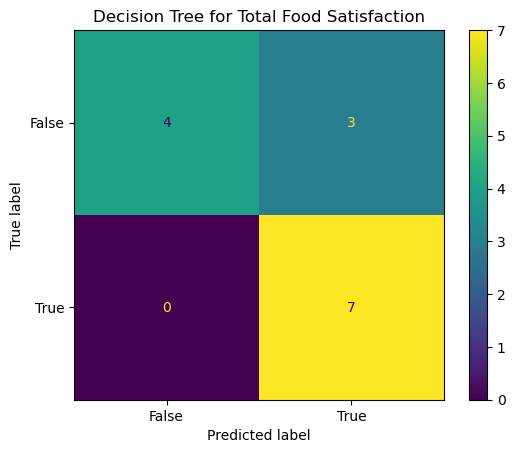

In [45]:
param_grid = {'max_depth': np.arange(1, 100)}
decision_tree_total_satisfaction = perform_grid_search(
    DecisionTreeClassifier(),
    x_total_train,
    y_total_train,
    x_total_test,
    y_total_test,
    param_grid,
    title='Decision Tree for Total Food Satisfaction'
)